In [2]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from sklearn.metrics import f1_score, confusion_matrix
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns

In [ ]:
# chosen dataset -> fashion mnist dataset

# data perprocessing and augmentation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [3]:
# load fashion mnist 
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainLoader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testLoader = DataLoader(testset, batch_size=64, shuffle=True)

In [4]:
class FashionClassifier(nn.Module):
    def __init__(self):
        super(FashionClassifier, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(p=0.2)


    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim = 1)
        return x

In [5]:
model = FashionClassifier()

In [6]:
# adjusting the hyperparameters
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

In [7]:
# adjusting batch sizes, learning rates and implementing a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

In [8]:
epochs = 10
steps = 0
train_losses, test_losses = [], []

In [11]:
for e in range(epochs):
    running_loss = 0
    for images, labels in trainLoader:
        optimizer.zero_grad()

        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    else:
        test_loss = 0
        accuracy = 0


        # turn of predictions for validation 
        with torch.no_grad():
            model.eval()
            for images, labels in testLoader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        model.train()

        train_losses.append(running_loss/len(trainLoader))
        test_losses.append(test_loss/len(testLoader))

        print(f"Epoch {e+1}/{epochs}.. "
              f"Train loss: {running_loss/len(trainLoader):.2f}.. "
              f"Test loss: {test_loss/len(testLoader):.2f}.. "
              f"Test accuracy: {accuracy/len(testLoader):.2f}")
        scheduler.step()

Epoch 1/10.. Train loss: 0.30.. Test loss: 0.35.. Test accuracy: 0.88
Epoch 2/10.. Train loss: 0.28.. Test loss: 0.34.. Test accuracy: 0.88
Epoch 3/10.. Train loss: 0.27.. Test loss: 0.34.. Test accuracy: 0.88
Epoch 4/10.. Train loss: 0.26.. Test loss: 0.32.. Test accuracy: 0.89
Epoch 5/10.. Train loss: 0.25.. Test loss: 0.31.. Test accuracy: 0.89
Epoch 6/10.. Train loss: 0.24.. Test loss: 0.33.. Test accuracy: 0.89
Epoch 7/10.. Train loss: 0.23.. Test loss: 0.31.. Test accuracy: 0.89
Epoch 8/10.. Train loss: 0.23.. Test loss: 0.32.. Test accuracy: 0.89
Epoch 9/10.. Train loss: 0.22.. Test loss: 0.31.. Test accuracy: 0.89
Epoch 10/10.. Train loss: 0.21.. Test loss: 0.31.. Test accuracy: 0.90


In [12]:
# model model -> evaluation mode
model.eval()

FashionClassifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [13]:
# collect all predictions and true labels here
all_predictions = []
true_labels = []

In [14]:
with torch.no_grad():
    for images, labels in testLoader:
        # forward pass
        log_ps = model(images)
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)

        all_predictions.extend(top_class.view(-1).tolist())
        true_labels.extend(labels.tolist())

In [15]:
# convert lists into numpy arrays for sklearn functions
all_predictions = np.array(all_predictions)
true_labels = np.array(true_labels)

In [16]:
# calculate the accuracy
accuracy = np.mean(all_predictions == true_labels)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.90


In [17]:
# calculate the f1 score
f1 = f1_score(true_labels, all_predictions, average='weighted')
print(f"f1 score: {f1:.2f}")

f1 score: 0.90


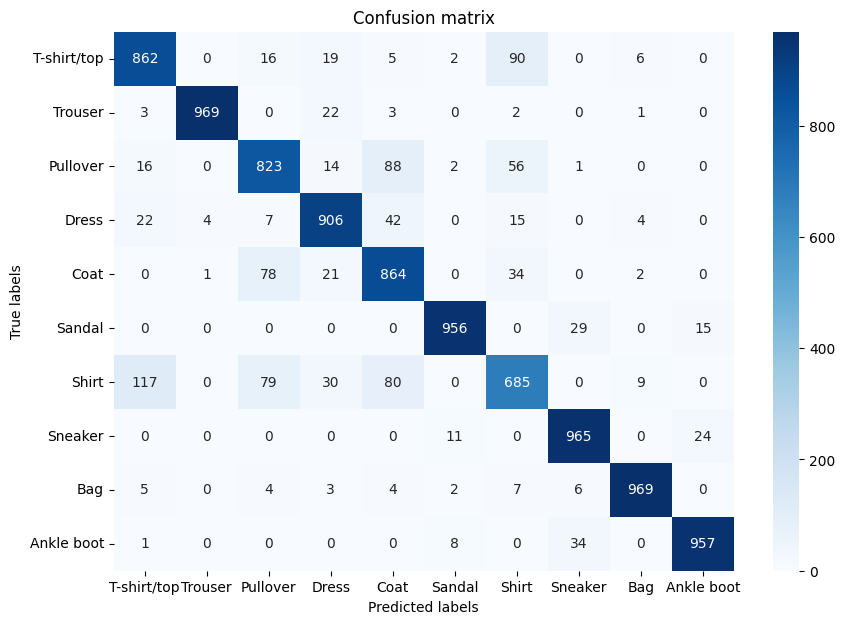

In [18]:
# plot the confusion matrix
conf_matrix = confusion_matrix(true_labels, all_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=trainset.classes, yticklabels=trainset.classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

In [ ]:
# confusion matrix explained

# most classes are predicted correctly, the confusion matrix is diagonally dominant

# tshirts/tops are mostly classified correctly from all of the classes
# coats are mainly confused with pullovers and dresses
# dresses have some confusion with coats and shirts as well
# sandals are very well classified, with some confusion with sneakers and ankle boots

# potential improvements
# more layers to decrease confusion
# higher amount of training data
# using convolutional neural networks which can learn to recognize more complex patterns, details